In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table  

In [3]:
## Считываем данные
data = pd.read_csv('credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [4]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

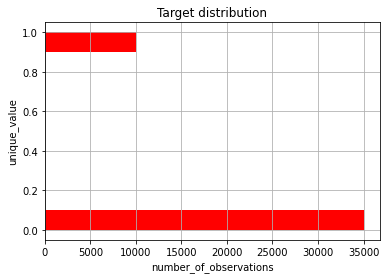

In [5]:
## Посмотрим на распределение классов в зависимой переменной

ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [6]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [7]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)

In [8]:
## Разделяем таргет и признаки 
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [9]:
### Ваш код должен быть здесь ###
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
neg = table[table['SeriousDlqin2yrs'] == 0]['age'].values
pos = table[table['SeriousDlqin2yrs'] == 1]['age'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
neg_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(neg, 1000)]
pos_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(pos, 1000)]

#  выводим интервальную оценку среднего
print("neg age:  mean interval",  stat_intervals(neg_mean_scores, 0.1))
print("pos age:  mean interval",  stat_intervals(pos_mean_scores, 0.1))

neg age:  mean interval [52.59069983 52.85581385]
pos age:  mean interval [45.70569021 46.14615001]


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [11]:
### Ваш код должен быть здесь ###
gcv = GridSearchCV(lr, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf, verbose=1)
gcv = gcv.fit(X, y)
gcv.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.6s finished


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
### Ваш код должен быть здесь ###
print(gcv.cv_results_['std_test_score'][1])
print(gcv.best_score_)

0.008137559189742445
0.8089120626797153


In [13]:
### Ваш код должен быть здесь ###
from sklearn.preprocessing import StandardScaler
lr = LogisticRegression(C=0.001,random_state=5, class_weight='balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


In [14]:
### Ваш код должен быть здесь ###
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.11426375283065268


In [15]:
### Ваш код должен быть здесь ###
lr = LogisticRegression(C=0.001,  random_state=5, class_weight= 'balanced')
lr.fit(X, y)

pd.DataFrame({'feat': independent_columns_names,
              'coef': lr.coef_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.446832
3,NumberOfTimes90DaysLate,0.390381
4,NumberOfTime60-89DaysPastDueNotWorse,0.216038
6,NumberOfDependents,0.191726
2,DebtRatio,-0.000006
5,MonthlyIncome,-0.000011
0,age,-0.013656


In [17]:
np.exp(lr.coef_[0][0]*20)

0.7610086991667803

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

In [20]:
rf_grid_search = GridSearchCV(rf, parameters, n_jobs=-1, 
                              scoring ='roc_auc', cv=skf,
                             verbose=1)
rf_grid_search = rf_grid_search.fit(X, y)
print(rf_grid_search.best_score_ - gcv.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  7.9min finished


0.026805420792832102


In [21]:
(rf_grid_search.best_score_ - gcv.best_score_) / rf_grid_search.best_score_

0.03207473975708998

In [23]:
rf = rf_grid_search.best_estimator_

In [25]:
pd.DataFrame({'feat': independent_columns_names,
              'coef': rf.feature_importances_.flatten().tolist()}).sort_values(by='coef', ascending=False)

,feat,coef
3,NumberOfTimes90DaysLate,0.314934
1,NumberOfTime30-59DaysPastDueNotWorse,0.295335
4,NumberOfTime60-89DaysPastDueNotWorse,0.128935
0,age,0.100434
2,DebtRatio,0.089620
5,MonthlyIncome,0.059142
6,NumberOfDependents,0.011600


In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

In [31]:
bg = BaggingClassifier(LogisticRegression(class_weight='balanced'),
                       n_estimators=100, n_jobs=-1, random_state=42)
r_grid_search = RandomizedSearchCV(bg, parameters, n_jobs=-1, 
                                   scoring ='roc_auc', cv=skf, 
                                   n_iter=20, random_state=1,
                                  verbose=True)
r_grid_search = r_grid_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
r_grid_search.best_score_